In [1]:
import os
import sys
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
import glob
import lmfit
from scipy.ndimage import gaussian_filter1d

parent_parent_dir = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(parent_parent_dir)
import scresonators.src as scres
import scresonators.src.plotter as plotter

# from bcqt-ctrl repo
# import helper_functions as hf

from pathlib import Path
from time import sleep, time
# from tqdm.auto import tqdm


In [2]:
# # from src.dcm import DCM
# # from src.fitter import Fitter
# cur_dir = os.getcwd()
# print(cur_dir)
# parent_parent_dir = os.path.dirname(os.path.dirname(cur_dir))
# sys.path.append(parent_parent_dir)
# import scresonators as scres

# # Mocking Fitter.find_circle to return predefined values for the test
# # Fitter.find_circle = staticmethod(lambda x, y: (0.5, 0.5, 1.0))

# # def dcm_instance():
# #     return scres.src.fit_methods.dcm.DCM()

# # dcm1 = dcm_instance() #instantiated the dcm class
# # #arguments of func: (x, Q, Qc, w1, phi)
# # dcm1_func = dcm1.func()

# func = 1 - Q / Qc * np.exp(1j * phi) / (1 + 1j * (x - w1) / w1 * 2 * Q)

In [3]:
def simulate_data(Q, Qc, phi, w1, num_points, freq_range):
    """
    Generates simulated data for the given function as a function of frequency x.

    Args:
        Q (float): Quality factor.
        Qc (float): Coupling quality factor.
        phi (float): Phase angle in radians.
        w1 (float): Resonant frequency.
        num_points (int): Number of points in the frequency range. Default is 100.
        freq_range (tuple): Frequency range as (min_freq, max_freq). Default is (0, 10).

    Returns:
        freqs (np.ndarray): Array of frequency values.
        data (np.ndarray): Array of complex data values for each frequency.
    """
    # Generate frequency values
    freqs = np.linspace(freq_range[0], freq_range[1], num_points)
    
    # Calculate the complex data values
    data = 1 - Q / Qc * np.exp(1j * phi) / (1 + 1j * (freqs - w1) / w1 * 2 * Q)
    
    return freqs, data

# Plotting function
# Custom formatter function to ensure each tick label has the actual frequency (not just 0.00050, 0.00055, etc with +4.512 on the lower right side)
def custom_formatter1(x, pos):
    return f'{x:.5f}'


def _estimate_initial_parameters(f_data, phase):
        """Estimate initial parameters for the fitting process.
        
        Args: 
            f_data (np.ndarray): array of frequency data (Hz), an array of floats
            phase (np.ndarray): phase data (radians), an array of floats

        Returns:
            fr_guess (float): guess of resonant frequency (Hz)
            Ql_guess (float): guess of loaded quality factor 
            delay_guess (float): guess of cable time delay (s) ## not sure about this...
        """
        phase_smooth = gaussian_filter1d(phase, 30) ## should we unwrap phases first or is that redundant?
        fr_guess = f_data[np.argmax(np.gradient(phase_smooth))] 
        Ql_guess = 2 * fr_guess / (f_data[-1] - f_data[0])
        delay_guess = -(np.ptp(phase) / (2 * np.pi * (f_data[-1] - f_data[0])))
        return  fr_guess, Ql_guess, delay_guess

In [4]:
Q = 1e5
Qc = 1e5
phi = 0.2
w1 = 5e9
num_points = 50
freq_range = (4.9999e9, 5.00010e9)

freqs, cmplx = simulate_data(Q, Qc, phi, w1, num_points, freq_range)
amps_linear = np.abs(cmplx)
amps_dB = 20*np.log10(amps_linear)
phases = np.angle(cmplx)
# cmplx = amps*np.exp(1j*phases) ## THIS IS INCORRECT! NOT EQUAL TO OUTPUT OF 'simulate_data'
# print(cmplx == data)

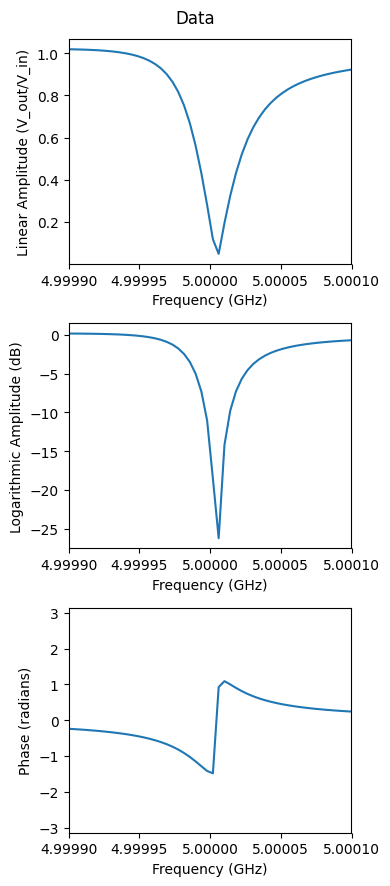

In [5]:
plt.figure(figsize=(4, 9))

xlim_min = 4.9999
xlim_max = 5.00010

plt.subplot(3,1,1)
plt.plot(freqs/1e9, amps_linear)
plt.xlabel('Frequency (GHz)')
plt.ylabel('Linear Amplitude (V_out/V_in)')
plt.xlim(xlim_min, xlim_max)
# plt.ylim(0,10)
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(custom_formatter1)) # Set the formatter for the x-axis

plt.subplot(3,1,2)
plt.plot(freqs/1e9, amps_dB)
plt.xlabel('Frequency (GHz)')
plt.ylabel('Logarithmic Amplitude (dB)')
plt.xlim(xlim_min, xlim_max)
# plt.ylim(0,10)
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(custom_formatter1)) # Set the formatter for the x-axis

plt.subplot(3,1,3)
plt.plot(freqs/1e9, phases)
plt.xlabel('Frequency (GHz)')
plt.ylabel('Phase (radians)')
plt.xlim(xlim_min, xlim_max)
plt.ylim(-np.pi, np.pi)
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(custom_formatter1)) # Set the formatter for the x-axis

plt.suptitle('Data')
plt.tight_layout()
plt.show()

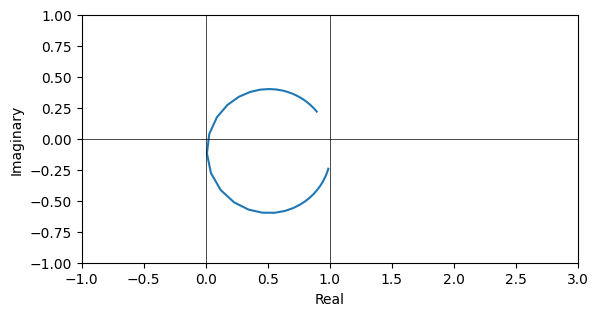

In [6]:
# Plot the real and imaginary parts of the data


plt.plot(cmplx.real, cmplx.imag)
plt.xlabel('Real')
plt.ylabel('Imaginary')
plt.xlim(-1,3)
plt.ylim(-1,1)
plt.axhline(0, color='black', linewidth=0.5)  # Add horizontal line at y=0
plt.axvline(1, color='black', linewidth=0.5)  # Add vertical line at x=1
plt.axvline(0, color='black', linewidth=0.5)  # Add vertical line at x=0
plt.gca().set_aspect('equal', adjustable='box') # Set aspect of the plot to be equal


### Try to fit to the simulated data with initial guesses and save data to csv files

Delay from 'fit_delay':  -134.52695075359077 ns


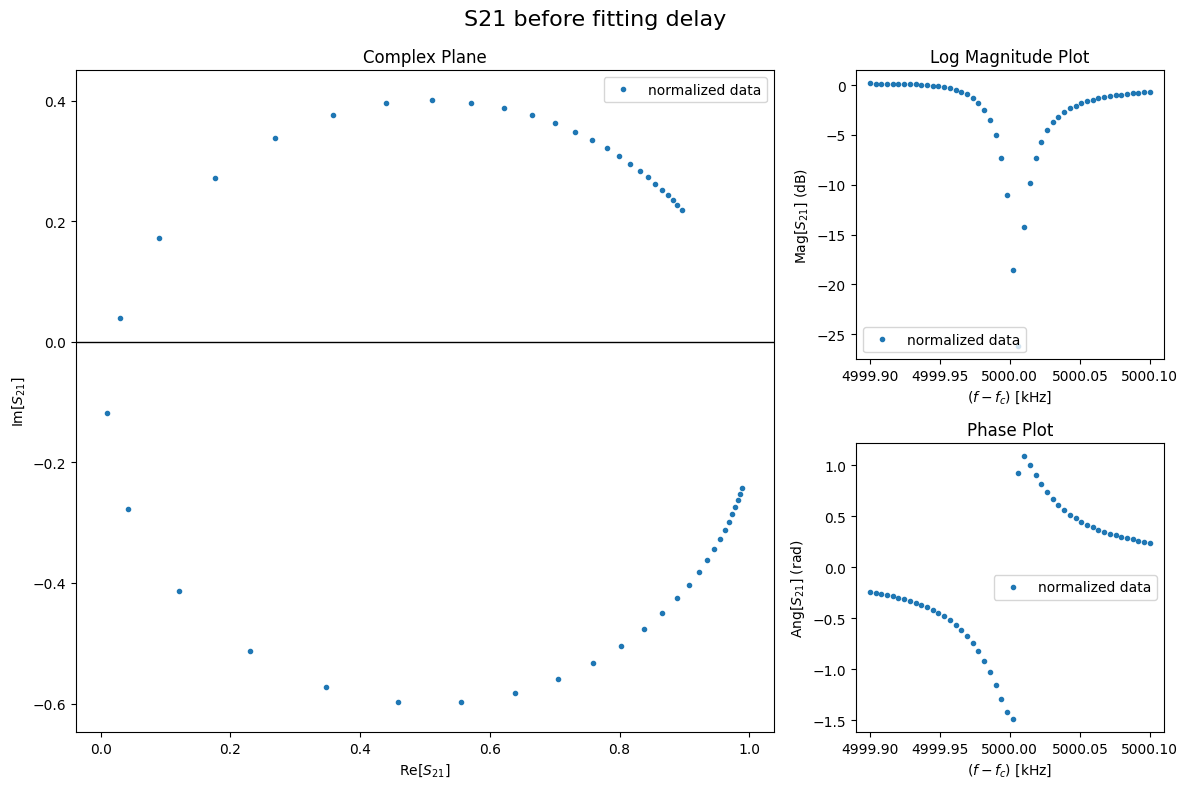

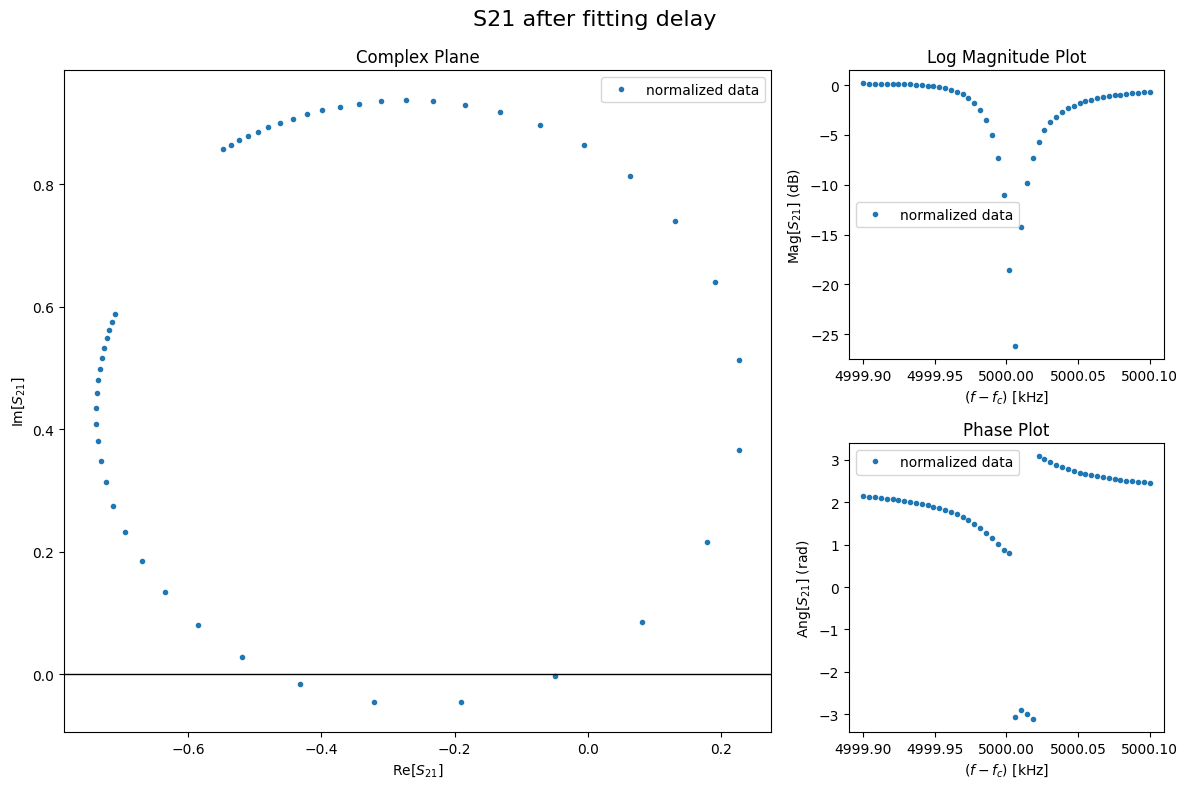

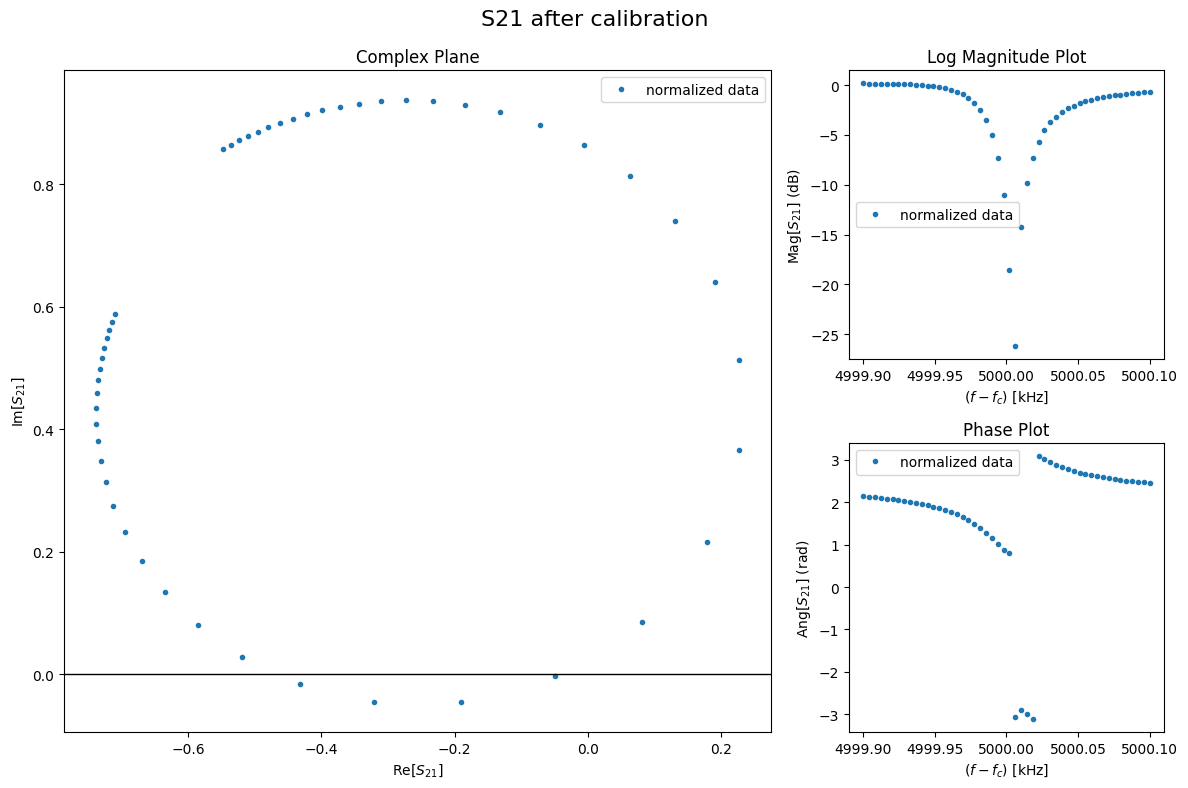

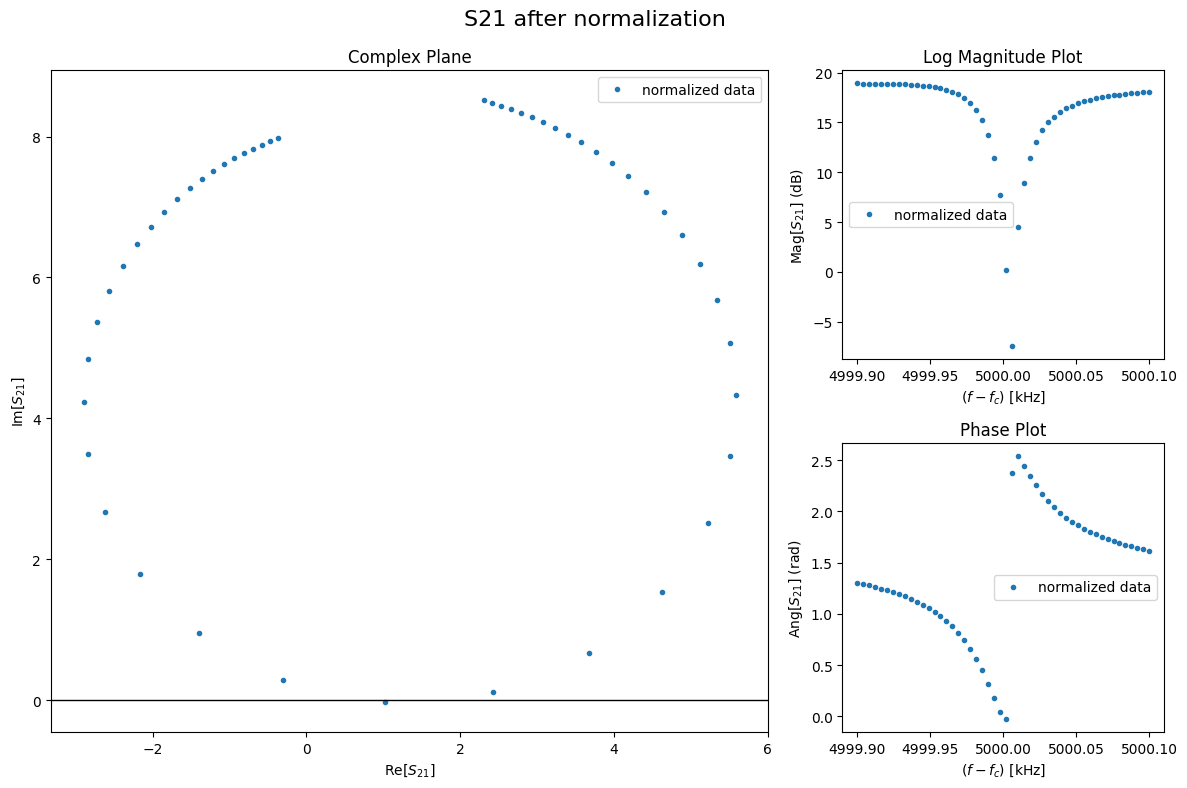

In [7]:
dcm_method = scres.fit_methods.dcm.DCM() ## Making an instance of DCM class. 
FitRes = scres.Fitter(dcm_method, preprocess='circle', normalize=4, MC_rounds=1000, MC_step_const=0.05, MC_weight=False, MC_fix=[], databg=None) ## Making instance of Fitter class.
## if I wanted to use kwargs: FitRes = scres.Fitter(dcm_method, preprocess='linear')

w1_guess, _, _ = _estimate_initial_parameters(freqs, phases)
init_guess = {
    'Q' : {'value' : 1e5, 'min' : 1e3, 'max' : 1e9},
    'Qc' : {'value' : 1e5, 'min' : 1e3, 'max' : 1e9},
    'w1' : {'value' : w1_guess, 'min' : w1_guess-3e3, 'max' : w1_guess+3e3, 'vary' : True},
    'phi' : {'value' : 0, 'min' : -np.pi/2, 'max' : np.pi/2}, 
}

init_guess_df = pd.DataFrame(init_guess)
# print(init_guess_df)

labels_guess_array = np.array(['value', 'min', 'max', 'vary'])
Q_guess_array = init_guess_df['Q'].to_numpy()
Qc_guess_array = init_guess_df['Qc'].to_numpy()
w1_guess_array = init_guess_df['w1'].to_numpy()
phi_guess_array = init_guess_df['phi'].to_numpy()

init_params = lmfit.create_params(**init_guess)
# init_params.pretty_print()

result, conf_intervals = FitRes.fit(freqs, amps_dB, phases, manual_init=init_params, verbose=False) ## set verbose=True if you want extra outputs

fit_result_params = result.params
# print("Fit result params", fit_result_params)
# print("data type", type(fit_result_params))

labels_results_array = np.array(['value', 'stderr'])
Q_result_array = np.array([fit_result_params['Q'].value, fit_result_params['Q'].stderr])
Qc_result_array = np.array([fit_result_params['Qc'].value, fit_result_params['Qc'].stderr])
w1_result_array = np.array([fit_result_params['w1'].value, fit_result_params['w1'].stderr])
phi_result_array = np.array([fit_result_params['phi'].value, fit_result_params['phi'].stderr])

# Log ('save', not 'logarithmic') fitted data, initial guesses, and data into a csv file
# First begin by making two separate dataframes
data_s21 = {
    'Frequency (Hz)': freqs,
    'Amplitude (dB)': amps_dB,
    'Phase (radians)': phases
}
df_s21 = pd.DataFrame(data_s21)

data_guesses = {
    'Initial Guesses Table': labels_guess_array,
    'Q': Q_guess_array,
    'Qc': Qc_guess_array,
    'w1 (Hz)': w1_guess_array,
    'phi (radians)': phi_guess_array
}
df_guesses = pd.DataFrame(data_guesses)

data_results = {
    'Parameter Results Table': labels_results_array,
    'Q': Q_result_array,
    'Qc': Qc_result_array,
    'w1 (Hz)': w1_result_array,
    'phi (radians)': phi_result_array
}
df_results = pd.DataFrame(data_results)

# Concatenate the dataframes
df_concatenated1 = pd.concat([df_s21, df_guesses], axis=1)
df_concatenated2 = pd.concat([df_concatenated1, df_results], axis=1)

# Save the DataFrame to a CSV file
csv_name = 'dcm_3_circle'
csv_path = f'simulated_data/{csv_name}.csv'
df_concatenated2.to_csv(csv_path, index=False)

114.73781545344305 473029.68485247326 542743.926846034

abs(data):  [1.01833837 1.01779119 1.01708414 1.01618127 1.01503753 1.01359604
 1.01178451 1.00951033 1.00665395 1.00305967 0.99852301 0.99277291
 0.98544687 0.97605586 0.96393495 0.94817458 0.92752705 0.90028564
 0.86414476 0.81607982 0.75235195 0.66885618 0.56213756 0.43127053
 0.28007821 0.11832844 0.04889811 0.1948355  0.32410807 0.43227102
 0.52051706 0.59169926 0.6489894  0.69525979 0.73288478 0.76374123
 0.78928149 0.81062022 0.82861223 0.84391539 0.85703908 0.86838064
 0.87825255 0.88690258 0.89452887 0.90129114 0.90731917 0.91271919
 0.91757882 0.92197079]
result:  [ 1.23021909-0.0120122j   1.23982971-0.01303908j  1.25027497-0.01420333j
  1.26166811-0.01553058j  1.27414378-0.01705269j  1.28786322-0.01880969j
  1.30302126-0.02085244j  1.31985536-0.02324632j  1.33865799-0.02607647j
  1.35979331-0.02945548j  1.38372043-0.0335346j   1.41102614-0.03852083j
  1.44247207-0.04470345j  1.47906399-0.05249644j  1.52215633-0.06250858

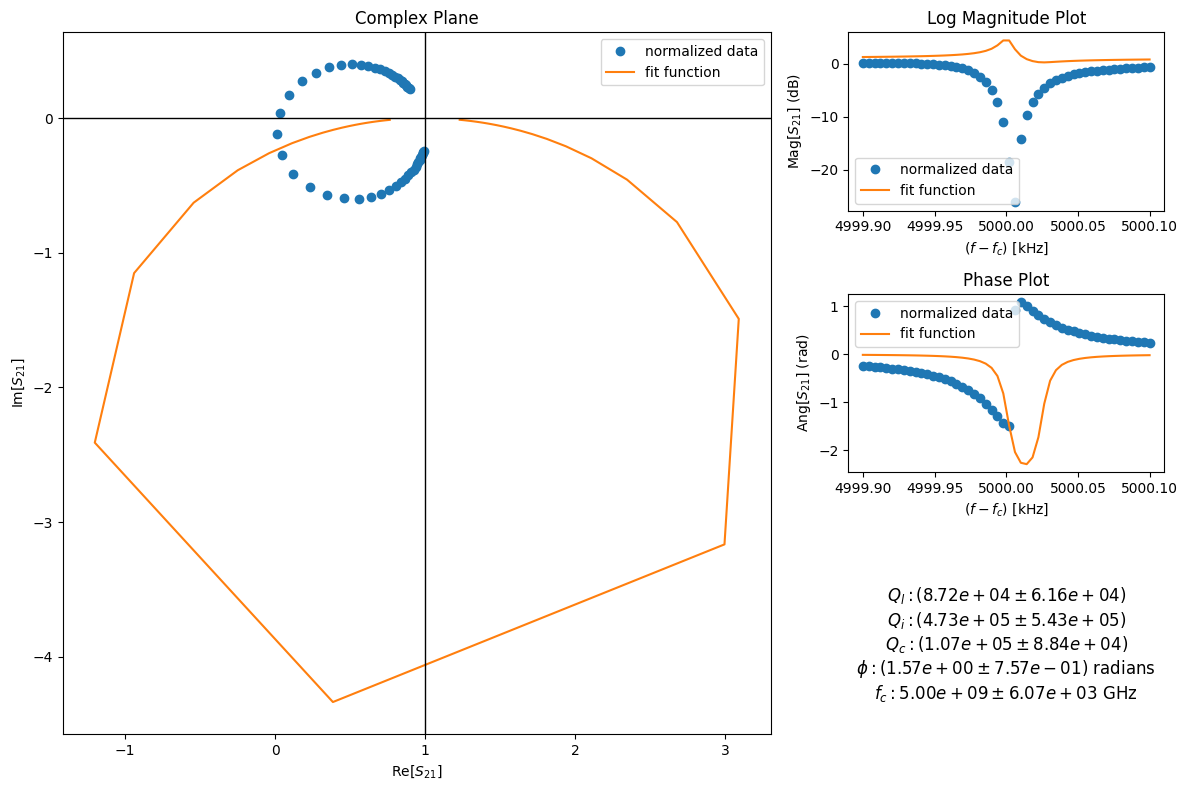

In [8]:
cmplx_fit = result.eval(params=fit_result_params, x=freqs)
# cmplx_fit_err = result.eval_uncertainty()
Q_val = fit_result_params["Q"].value
Q_err = fit_result_params["Q"].stderr
dQ = 100 * Q_err/Q_val
print(dQ, Q_val, Q_err)

print("\nabs(data): ", np.abs(cmplx))
print("result: ", cmplx_fit)

##########################################
#############    plotting   ##############
##########################################

def calculate_Ql(Q_i, sigma_Qi, Q_c, sigma_Qc):
    # TODO Decide if we need this to be a separate method in Plotter class. What is most efficient?

    # Calculate Ql
    Q_l = (1 / Q_i + 1 / Q_c) ** -1

    # Calculate partial derivatives
    dQl_dQi = -Q_l**2 / Q_i**2
    dQl_dQc = -Q_l**2 / Q_c**2

    # Propagate errors
    sigma_Ql = np.sqrt((dQl_dQi * sigma_Qi)**2 + (dQl_dQc * sigma_Qc)**2)

    return Q_l, sigma_Ql


Ql_value, Ql_stderr = calculate_Ql(fit_result_params['Q'].value, fit_result_params['Q'].stderr, fit_result_params['Qc'].value, fit_result_params['Qc'].stderr)

layout = [
    ["main", "main", "mag"],
    ["main", "main", "ang"],
    ["main", "main", "text"]
]

fig, ax_dict = plt.subplot_mosaic(layout, figsize=(12, 8))

def custom_formatter2(x, pos):
    return f'{x / 1e6:.2f}'

# Main plot (complex plane)
ax = ax_dict["main"]
ax.plot(cmplx.real, cmplx.imag, 'o', label="normalized data")
ax.plot(cmplx_fit.real, cmplx_fit.imag, label="fit function")
ax.set_xlabel("Re[$S_{21}$]")
ax.set_ylabel("Im[$S_{21}$]")
ax.axhline(y=0, color='black', linewidth=1)
ax.axvline(x=1, color='black', linewidth=1)
# ax.set_xlim(-0.05, 1.05)
# ax.set_ylim(-0.55, 0.55)
ax.set_title("Complex Plane")
ax.legend()

# Magnitude plot
ax_mag = ax_dict["mag"]
ax_mag.plot(freqs, amps_dB, 'o', label="normalized data")
ax_mag.plot(freqs, np.abs(cmplx_fit), label="fit function")
ax_mag.set_xlabel("$(f - f_c)$ [kHz]")
ax_mag.set_ylabel("Mag[$S_{21}$] (dB)")
ax_mag.set_title("Log Magnitude Plot")
ax_mag.xaxis.set_major_formatter(ticker.FuncFormatter(custom_formatter2))
ax_mag.legend()

# Phase plot
ax_ang = ax_dict["ang"]
ax_ang.plot(freqs, phases, 'o', label="normalized data")
ax_ang.plot(freqs, np.angle(cmplx_fit), label="fit function")
ax_ang.set_xlabel("$(f - f_c)$ [kHz]")
ax_ang.set_ylabel("Ang[$S_{21}$] (rad)")
ax_ang.set_title("Phase Plot")
ax_ang.xaxis.set_major_formatter(ticker.FuncFormatter(custom_formatter2))
ax_ang.legend()

# Text box
ax_text = ax_dict["text"]
ax_text.axis("off")
textstr = '\n'.join((
    f'$Q_l: ({Ql_value:.2e} \pm {Ql_stderr:.2e})$',
    f'$Q_i: ({fit_result_params["Q"].value:.2e} \pm {fit_result_params["Q"].stderr:.2e})$',
    f'$Q_c: ({fit_result_params["Qc"].value:.2e} \pm {fit_result_params["Qc"].stderr:.2e})$',
    f'$\phi: ({fit_result_params["phi"].value:.2e} \pm {fit_result_params["phi"].stderr:.2e})$ radians',
    f'$f_c: {fit_result_params["w1"].value:.2e} \pm {fit_result_params["w1"].stderr:.2e}$ GHz'
))

ax_text.text(0.5, 0.5, textstr, fontsize=12, verticalalignment='center', horizontalalignment='center', transform=ax_text.transAxes)

plt.tight_layout()
plt.show()

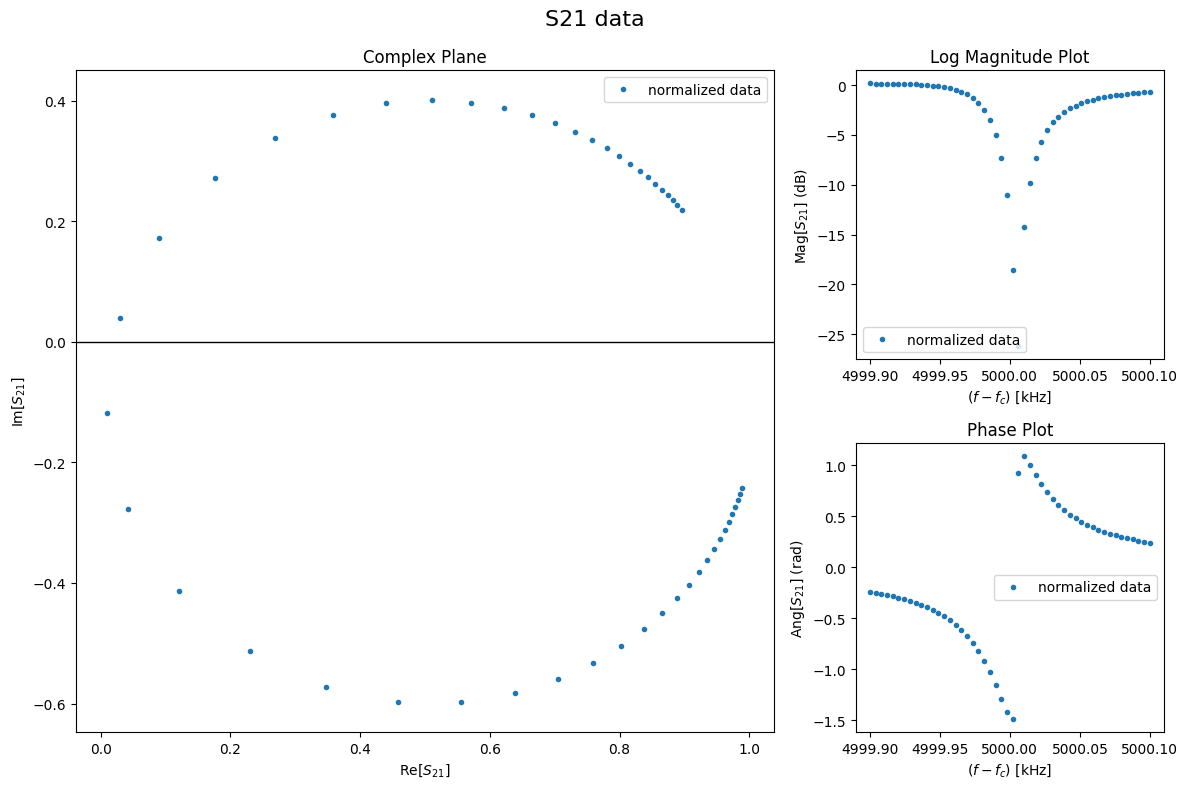

In [9]:
plot = plotter.Plotter(freqs, cmplx)

plot.plot_before_fit()

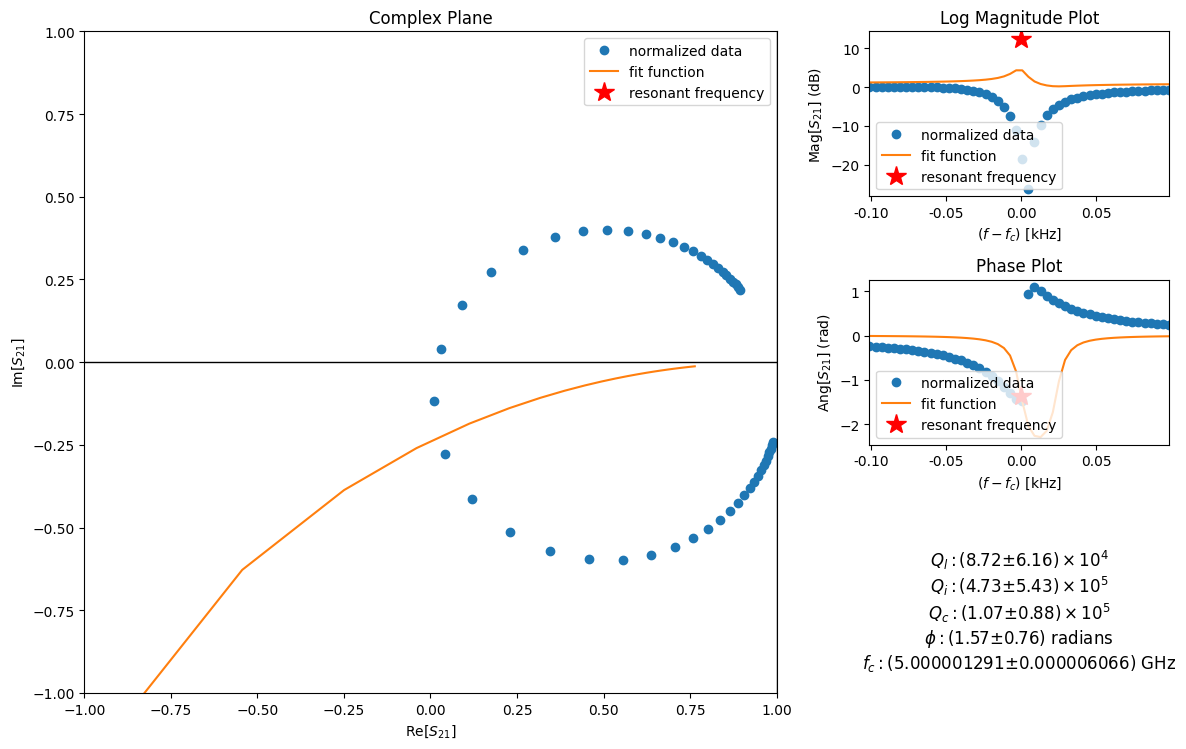

In [10]:
plot.plot_dcm(cmplx_fit, fit_result_params)